In [1]:
import tensorflow as tf

### Configuration
create_dataset = False

def in_google_colab():
    """Checks if the code is running in Google Colab

    Returns:
        bool: _description_
    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

if in_google_colab():
    print("Running in Google Colab")
    # Install necessary packages in Google Colab
    !rm -r sample_data/
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !cp -r anesthesia_anomaly_detection/* .
    !rm -r anesthesia_anomaly_detection/
    !pip install vitaldb
    create_dataset = False
else:
    print("Running locally")

### Datasetpath
directory = 'data/'
datasetpath = 'dataset02/'
vitaldbpath = 'vitaldb_tiva/'

### Import the necessary libraries
import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt

### Custom functions
import modules as md

Running in Google Colab
Cloning into 'anesthesia_anomaly_detection'...
remote: Enumerating objects: 428, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 428 (delta 70), reused 138 (delta 48), pack-reused 264
Receiving objects: 100% (428/428), 73.94 MiB | 16.28 MiB/s, done.
Resolving deltas: 100% (170/170), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.2 MB/s eta 0:00:00


In [2]:
###### Create Dataset
if create_dataset:
    bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    bis.name = 'Bispektralindex'
    bis.tracks = ['BIS/BIS']
    bis.filter = [20, 10, 100]
    bis.generateDataset(normalization=md.NormNone)
    bis.save('00_bis.npz')

    info = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    info.generateDataset(normalization=md.NormStandard)
    info.save('01_info.npz')

    bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    bloodpressure.name = 'bloodpressure'
    bloodpressure.tracks = ['Solar8000/ART_DBP', 'Solar8000/ART_MBP', 'Solar8000/ART_SBP']
    bloodpressure.filter = [20, 20, 250]
    bloodpressure.generateDataset(normalization=md.NormStandard)
    bloodpressure.save('02_bloodpressure.npz')

    etCO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    etCO2.name = 'End Tidal CO2'
    etCO2.tracks = ['Primus/ETCO2']
    etCO2.filter = [5, 15, 50]
    etCO2.generateDataset(normalization=md.NormStandard)
    etCO2.save('02_etCO2.npz')

    spO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    spO2.name = 'SpO2'
    spO2.tracks = ['Solar8000/PLETH_SPO2']
    spO2.filter = [3, 80, 100]
    spO2.generateDataset(normalization=md.NormStandard)
    spO2.save('02_spO2.npz')

    hr = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    hr.name = 'Heart Rate'
    hr.tracks = ['Solar8000/HR']
    hr.filter = [20, 40, 180]
    hr.generateDataset(normalization=md.NormStandard)
    hr.save('02_hr.npz')

    propofolrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    propofolrate.name = 'Propofol Rate'
    propofolrate.tracks = ['Orchestra/PPF20_RATE']
    propofolrate.filterON = False
    propofolrate.generateDataset(normalization=md.NormNone)
    propofolrate.save('03_propofol_rate.npz')

    remifentanilrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    remifentanilrate.name = 'Remifentanil Rate'
    remifentanilrate.tracks = ['Orchestra/RFTN20_RATE']
    remifentanilrate.filterON = False
    remifentanilrate.generateDataset(normalization=md.NormNone)
    remifentanilrate.save('03_remifentanil_rate.npz')

### Load the datasets
bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

info = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info.load('01_info.npz')

bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bloodpressure.load('02_bloodpressure.npz')

etCO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
etCO2.load('02_etCO2.npz')

spO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
spO2.load('02_spO2.npz')

hr = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
hr.load('02_hr.npz')

propofolrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
propofolrate.load('03_propofol_rate.npz')

remifentanilrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
remifentanilrate.load('03_remifentanil_rate.npz')

train_index, val_index, test_index = bis.split(np.array(bis.index))

In [ ]:
########################################## COMBINED MODEL ##########################################
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, ReLU, Dropout, Concatenate, Masking, Conv1D, MaxPooling1D, BatchNormalization, RepeatVector, Lambda
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

### Blood Pressure layers
input_bp = Input(shape=(None, bloodpressure.train_dataset.shape[2]))
bp_layer = Masking(mask_value=0.0)(input_bp)

bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=16, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=4, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = Dense(units=4, activation='linear')(bp_layer)

### etCO2 layers
input_co2 = Input(shape=(None, etCO2.train_dataset.shape[2]))

co2_layer = LSTM(units=64, return_sequences=True)(input_co2)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = LSTM(units=64, return_sequences=True)(co2_layer)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = LSTM(units=64, return_sequences=True)(co2_layer)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = LSTM(units=16, return_sequences=True)(co2_layer)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = LSTM(units=4, return_sequences=True)(co2_layer)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = Dense(units=4, activation='linear')(co2_layer)

# Propofol layers
input_propofol = Input(shape=(None, propofolrate.train_dataset.shape[2]))
propofol_layer = BatchNormalization()(input_propofol)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=64, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=16, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = LSTM(units=16, return_sequences=True)(propofol_layer)
propofol_layer = BatchNormalization()(propofol_layer)
propofol_layer = Dense(units=4, activation='linear')(propofol_layer)

# Remifentanil layers
input_remifentanil = Input(shape=(None, remifentanilrate.train_dataset.shape[2]))
remifentanil_layer = BatchNormalization()(input_remifentanil)
remifentanil_layer = LSTM(units=64, return_sequences=True)(remifentanil_layer)
remifentanil_layer = BatchNormalization()(remifentanil_layer)
remifentanil_layer = LSTM(units=64, return_sequences=True)(remifentanil_layer)
remifentanil_layer = BatchNormalization()(remifentanil_layer)
remifentanil_layer = LSTM(units=64, return_sequences=True)(remifentanil_layer)
remifentanil_layer = BatchNormalization()(remifentanil_layer)
remifentanil_layer = LSTM(units=64, return_sequences=True)(remifentanil_layer)
remifentanil_layer = BatchNormalization()(remifentanil_layer)
remifentanil_layer = LSTM(units=64, return_sequences=True)(remifentanil_layer)
remifentanil_layer = BatchNormalization()(remifentanil_layer)
remifentanil_layer = LSTM(units=16, return_sequences=True)(remifentanil_layer)
remifentanil_layer = BatchNormalization()(remifentanil_layer)
remifentanil_layer = LSTM(units=16, return_sequences=True)(remifentanil_layer)
remifentanil_layer = BatchNormalization()(remifentanil_layer)
remifentanil_layer = Dense(units=4, activation='linear')(remifentanil_layer)

### INFO layers
input_info = Input(shape=(info.train_dataset.shape[1],))
info_layer = RepeatVector(bloodpressure.train_dataset.shape[1])(input_info)
info_layer = Dense(units=16, activation='linear')(info_layer)
info_layer = Dense(units=16, activation='sigmoid')(info_layer)


## Concatenate the Propofol output with the info layer
comb_layer = Concatenate()([bp_layer, co2_layer, propofol_layer, info_layer])
comb_layer = Dense(units=64, activation='linear')(comb_layer)
comb_layer = Dense(units=64, activation='relu')(comb_layer)
comb_layer = Dense(units=64, activation='relu')(comb_layer)
comb_layer = Dense(units=32, activation='relu')(comb_layer)
comb_layer = Dense(units=16, activation='relu')(comb_layer)
comb_layer = Dense(units=1, activation='relu')(comb_layer)
output = Lambda(lambda x: x * 100)(comb_layer)

# Define the model
model = Model(inputs=[input_bp, input_co2, input_propofol, input_remifentanil, input_info], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['MeanSquaredError','MeanAbsoluteError','RootMeanSquaredError']
              )

#model.summary()
y = pd.DataFrame(bis.train_dataset[:,:,0].T).rolling(min_periods=1,window=3, center=True).mean().to_numpy().T[:,:,np.newaxis]

class StopTrainingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(StopTrainingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_loss') is not None:
            if logs.get('val_loss') < self.threshold:
                print(f"\nValidation loss is below {self.threshold}, stopping training.")
                self.model.stop_training = True

stop_training_callback = StopTrainingCallback(threshold = 35)

# Train the model
history = model.fit([bloodpressure.train_dataset, etCO2.train_dataset, propofolrate.train_dataset, remifentanilrate.train_dataset, info.train_dataset],
                    y,
                    validation_data=([bloodpressure.validation_dataset, etCO2.validation_dataset, propofolrate.validation_dataset, remifentanilrate.validation_dataset, info.validation_dataset], bis.validation_dataset),
                    epochs=150,
                    callbacks=[stop_training_callback],
                    batch_size=4
                    )

train_score = history.history

Epoch 1/150
28/28 [==============================] - 112s 2s/step - loss: 213.7815 - mean_squared_error: 213.7815 - mean_absolute_error: 9.2350 - root_mean_squared_error: 14.6213 - val_loss: 537.1343 - val_mean_squared_error: 537.1343 - val_mean_absolute_error: 19.9219 - val_root_mean_squared_error: 23.1762
Epoch 2/150
28/28 [==============================] - 41s 1s/step - loss: 101.7045 - mean_squared_error: 101.7045 - mean_absolute_error: 5.0815 - root_mean_squared_error: 10.0849 - val_loss: 579.2152 - val_mean_squared_error: 579.2151 - val_mean_absolute_error: 22.1784 - val_root_mean_squared_error: 24.0669
Epoch 3/150
28/28 [==============================] - 41s 1s/step - loss: 82.6339 - mean_squared_error: 82.6339 - mean_absolute_error: 4.5608 - root_mean_squared_error: 9.0903 - val_loss: 678.9374 - val_mean_squared_error: 678.9375 - val_mean_absolute_error: 23.1854 - val_root_mean_squared_error: 26.0564
Epoch 4/150
28/28 [==============================] - 42s 2s/step - loss: 63.12

In [ ]:
model.save('model_bis_propofol_info.keras')

# Training results

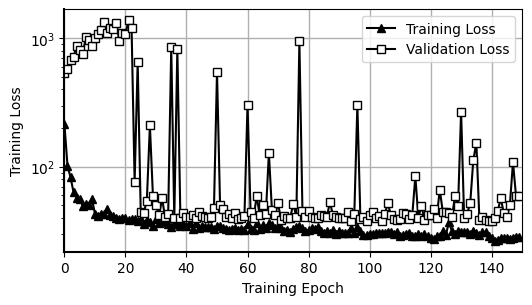

In [9]:
from utils.plotting import training_loss_plot

### Training Summary
plot = training_loss_plot(train_score)
plot.show()

# Testing

In [10]:
### Predict on the test set
from utils.evaluation import phases_report

y_pred =  model.predict([bloodpressure.test_dataset,etCO2.test_dataset, propofolrate.test_dataset, remifentanilrate.test_dataset, info.test_dataset], verbose=0)

phases_report(y_pred, bis.test_dataset, propofolrate.test_dataset)

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,85.22,139.87,6.88,7.55,9.23,11.83
Induction,154.86,637.60,9.58,18.34,12.44,25.25
Maintenance,62.48,60.90,6.10,5.68,7.90,7.80
Recovery,195.31,361.57,10.37,13.46,13.98,19.02


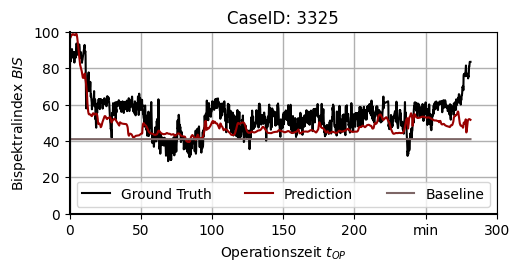

In [11]:
from utils.plotting import single_prediction_plot

plot = single_prediction_plot(5, test_index, bis.test_dataset, y_pred)
plot.show()

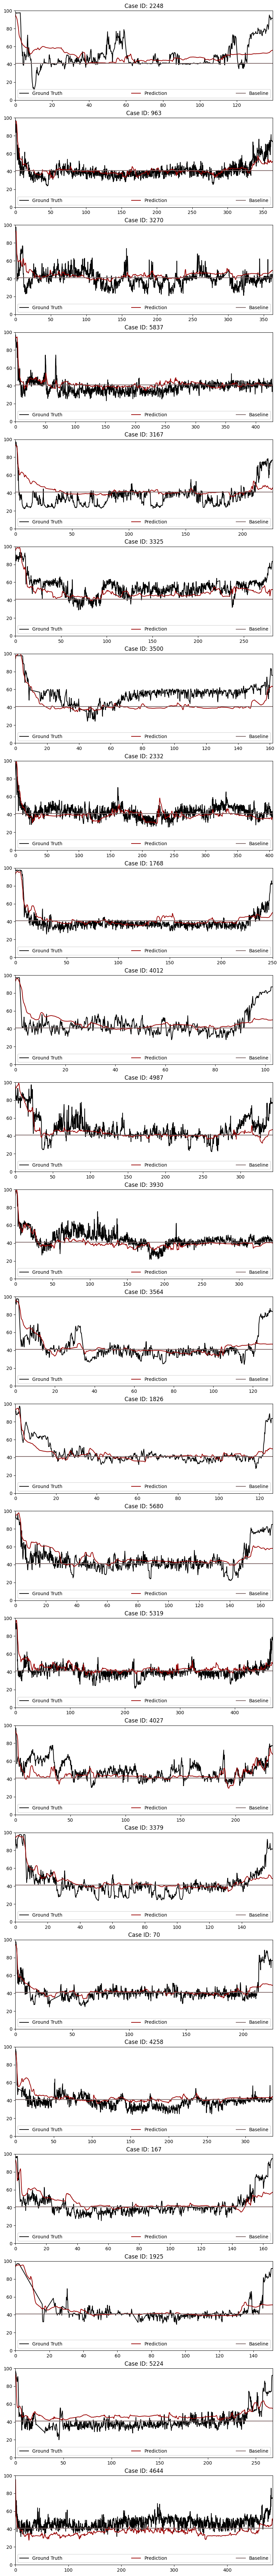

In [12]:
from utils.plotting import full_prediction_plot

full_prediction_plot(test_index, bis.test_dataset, y_pred)